# Data preprocessing and identification

In [ ]:
import os

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import math
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
text_neg = []
text_pos = []



def loaddata(path):
    numwords = []
    file = open(path, encoding="utf-8")
    texts_projects = []
    label_projects = []
    for line in file.readlines():
        line = line.strip("\n")
        a = line[13:].lower()
        if a == '':
            continue
        if a == '   ':
            continue
        if a == ' ':
            continue
        if a == '  ':
            continue
        texts_projects.append(a)

        counter = len(a.split(" "))
        numwords.append(counter)
        if line[4:12] == "negative":
            label_projects.append(0)
            text_neg.append(a)
        else:
            label_projects.append(1)
            text_pos.append(a)
    return texts_projects, label_projects, numwords

# Within-project SHAP

f1: 0.880794701986755


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


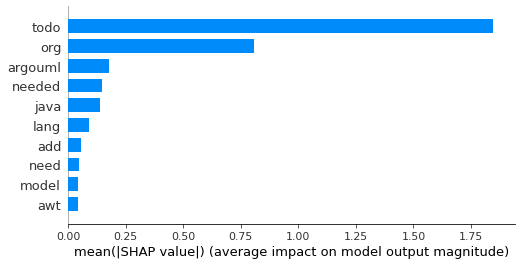

In [4]:
vocabulary = {"this": 0, "the": 1, "not": 2}
texts, labels, numwords = loaddata(r'./data/Arg_processing.csv')
idf = TfidfVectorizer(lowercase=False, max_features=1000,stop_words='english')
y = pd.Series(labels)
y = y.values.ravel()
x_tr, x_te, y_train, y_test = train_test_split(texts, y, test_size=0.1, shuffle=True, random_state=1)

# x_train = idf.fit_transform(x_tr)
# x_test = idf.transform(x_te)
x_train = idf.fit_transform(x_tr).toarray()
x_test = idf.transform(x_te).toarray()
from xgboost import XGBClassifier
gbm0 = LGBMClassifier(max_depth=15, num_leaves= 20, n_estimators=300)
gbm0.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=10, verbose=False)
y_predict = gbm0.predict(x_test)
y_pred = gbm0.predict(x_test)
y_predprob = gbm0.predict_proba(x_test)[:, 1]
# print("Accuracy:%.4f" % metrics.accuracy_score(y_test, y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict).ravel()
rec = tp / (tp + fn)
Recall = tp / (tp + fn)
specificity = tn / (fp + tn)
precision = tp / (tp + fp)
gmeans = math.sqrt(specificity * rec)
f1 = 2 * precision * rec / (precision + rec)
print("f1:", f1)
import shap

# Sparse matrix is supported by shap for lightgbm models.
imdb_lgb_explainer = shap.TreeExplainer(gbm0)
imdb_lgb_shap_values = imdb_lgb_explainer.shap_values(x_test)
if len(imdb_lgb_shap_values) == 2:
    imdb_lgb_shap_values = imdb_lgb_shap_values[1]
sorted_vocab = sorted(idf.vocabulary_.items(), key=lambda kv: kv[1])
sorted_vocab = [w for w, i in sorted_vocab]
import matplotlib.pyplot as plt

shap.summary_plot(imdb_lgb_shap_values, x_test, feature_names=sorted_vocab,
                  plot_type="bar", max_display=10, show=False, plot_size=.25)
plt.show()